In [33]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

print(tf.__version__)


2.5.0


In [34]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [35]:
os.listdir(dataset_dir)


['imdb.vocab', 'README', 'test', 'imdbEr.txt', 'train']

In [36]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_neg.txt',
 'unsup',
 'labeledBow.feat',
 'urls_pos.txt',
 'urls_unsup.txt',
 'neg',
 'pos',
 'unsupBow.feat']

In [37]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())
  #샘플파일 열기

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [38]:
#unsup 필요가 없어서 삭제하기
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [39]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [40]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])
    # ???? 
    #

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [41]:
print("Lavel 0 corresponds to", raw_train_ds.class_names[0])
print("Level 1 corresponds to", raw_train_ds.class_names[1])
#0이 negatice
#1이 positive

Lavel 0 corresponds to neg
Level 1 corresponds to pos


In [42]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [43]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)
#25000개 test set이 있음


Found 25000 files belonging to 2 classes.


In [44]:
#훈련을 위한 data set이 있음
# 토큰화 
# 벡터: 숫자를 변화시켜서 신경망으로 쓸 수 있도록 벡터로 바꾸기
#textvectorization은 완전하지 않음


In [45]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')
  #벡터화를 함수를이용해서 나타내줌
  #keras 모듈로는 완전하지 않아 stadardize로 없애고, vector로 만들어준다.
  #전처리 과정: 실제로는 tf보다는 파이썬 코딩 문자열 다루기 매서드를 활용함

In [46]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)
#max_tokens: 글자마자 숫자가 다르니/ 단어 갯수
#int(정수)로 바꿔서 
#sequense 길이도 맞춰줌
#max_features = 10000 -> 만개의 단어를 통해 문장들의 라벨을 판단하겠다
#문자를 숫자로 맞춰주기

In [47]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [48]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label
  #최종 벡터로 만든 텍스트

In [49]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))
#실제고 글씨가 있는 건은 숫자이고, 0은 글자가 없는 것.
#뒷문장과의 길이를 맞추기 위해서 하는 것

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [50]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [51]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)
#ds: data set


In [52]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
#cashe: 그전 자료 캐쉬를 활용
#prefetch: 뒤의 메모리 가져오기, 에러가 나면 prefetch를 없애기(메모리 많이 잡아먹음) 
#autotune: 자동으로 
#데이터 성능을 높여주는 작업
#데이터를 일정하게 
#batch로 하는 이유는? 텍스트는 시퀀스라 문맥이 있어서 한꺼번에 처리하기가 어려움, 

https://www.tensorflow.org/guide/data_performance?hl=ko

성능 향상에 대한 내용

Create the model

In [53]:
#임베딩: 맥락에 따라 해석 단어별로 가중치를 컴퓨터 설정하는 것
#벡터 공간에서 요소가 임의로 16개 차원으로 나타낸 것이다.
#컴퓨터가 좋은면 더 높게 한다. (스탠포드 교수,Andrew Ng )
 embedding_dim =16

In [54]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()
#sequential 쌓아주기
#dropout: overfitting 되는 것을 막아줌 ??
#globalaveragepooling1d:리뷰 단위 별로 긍정인지 부정인지 파악할 때, 여러가지 단어들의 weight를 파악하기 위해서 합쳐준다


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [57]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))
#losses.BinaryCrossentropy?
#logits=True?
#optimizer='adam'?
#metrics.BinaryAccuracy(threshold=0.0)): 2진분류였기 때문에 BinaryAccuracy를 사용함

학습

In [59]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)
#history에 담아줌
# validation_data=val_ds: matrix 값만 나온다. / loss는 무조건 나온다. merics가 지정하는대로 나온다.

Epoch 1/10
625/625 [==============================] - 12s 17ms/step - loss: 0.6628 - binary_accuracy: 0.6995 - val_loss: 0.6127 - val_binary_accuracy: 0.7750
Epoch 2/10
625/625 [==============================] - 4s 7ms/step - loss: 0.5458 - binary_accuracy: 0.8034 - val_loss: 0.4961 - val_binary_accuracy: 0.8228
Epoch 3/10
625/625 [==============================] - 4s 7ms/step - loss: 0.4425 - binary_accuracy: 0.8461 - val_loss: 0.4188 - val_binary_accuracy: 0.8462
Epoch 4/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3772 - binary_accuracy: 0.8664 - val_loss: 0.3729 - val_binary_accuracy: 0.8620
Epoch 5/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3346 - binary_accuracy: 0.8792 - val_loss: 0.3445 - val_binary_accuracy: 0.8678
Epoch 6/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3037 - binary_accuracy: 0.8887 - val_loss: 0.3255 - val_binary_accuracy: 0.8724
Epoch 7/10
625/625 [==============================] - 4s 7ms/s

평가

In [62]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy:",accuracy)

782/782 [==============================] - 9s 11ms/step - loss: 0.3104 - binary_accuracy: 0.8724
Loss:  0.3104264736175537
Accuracy: 0.8723999857902527


In [63]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

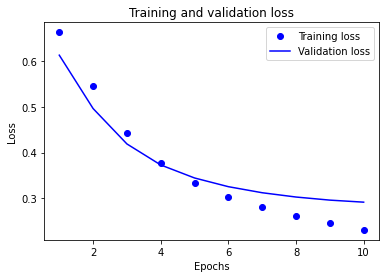

In [67]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

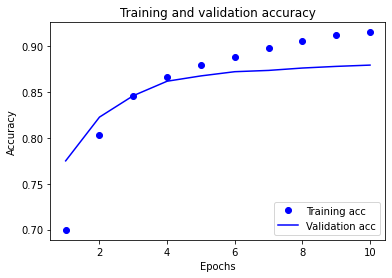

In [68]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [70]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])
#sigmoid: 0~1사이에 값 확률 이 존재, # 꼭 써야하는 경우? 2진분류/ 나머지는 relu를 많이 써줌
#전처리를 벡터화해서 학습했는데, 출력은 그냥 sequantiaㅣ그대로 출력

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)
#다시 logits를 true로 할 필요가 없음.
# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)


782/782 [==============================] - 10s 12ms/step - loss: 0.3104 - accuracy: 0.8724
0.8723999857902527


In [73]:
examples = [ "The movie was good!", "The movie was okay.", "The movie was worst..." ]

export_model.predict(examples)

array([[0.5187457 ],
       [0.42954504],
       [0.27873147]], dtype=float32)

In [84]:
examples = [
  "The movie was great!",
  "The movie was super nice",
  "The movie was okay.",
  "The movie was bad",
  "The movie was very bad",
  "The movie was terrible..."
]
export_model.predict(examples)

array([[0.6067387 ],
       [0.5372076 ],
       [0.42954504],
       [0.3515885 ],
       [0.38966262],
       [0.34637088]], dtype=float32)

부사에 대한 학습이 제대로 된 게 아니다, Very를 긍정의 값으로 해석했다.

데이터셋에 학습할 만한 부사조합 확인하기,
 RNN을 활용해 이어져있는 단어들을 잘 반영하여 
학습 성과를 높이기

https://www.youtube.com/watch?v=yXV_Torwzyc